In [ ]:
pip install finance-datareader

In [ ]:
!pip install opendartreader

In [ ]:
!pip install pykrx

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 256kB 30.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import OpenDartReader
import datetime
from pykrx import stock
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
api_key = '5729a47b92ddd434526831ee99ff01f65e6434db'
dart = OpenDartReader(api_key) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# file = pd.read_excel('/content/drive/MyDrive/소회의실 프로젝트/2021 금융데이터 경진대회_샘플_한국투자증권.xlsx')
file = pd.read_excel('/content/drive/MyDrive/소회의실 프로젝트/샘플_한국투자증권_9명.xlsx')

In [ ]:
file.head()

,고객번호,계좌번호,고객성별구분코드,동일나이군구분코드,주소(시도),주소(시군구),고객등록일자,계좌개설일자,주문일자,주문시각,최초주문번호,주문번호,상품번호,상품명,거래소구분코드,매도매수구분코드,주문구분코드,한국거래소호가조건코드,실주문단가,주문수량,정정취소구분코드,정정확인수량,취소확인수량,총체결건수,총체결수량,총체결금액,반대매매여부,예약주문여부,대출유형코드,대출일자,주문증거금율,전일종가,당일시가,일중고가,일중저가,당일종가,거래수량,거래대금,상한가여부,하한가여부
0,C0001_1,1A1111,1,10,경기,성남시,20200305,20200306,20200309,93944,1071,1071,00000A069500,삼성 KODEX200 증권상장지수투자신탁[주식],2,2,1,0,27000,59,0,0,0,1,59,1593000,N,N,0,NaN,100,27880,27000,27120,26525,26705,9069475,243062122350,N,N
1,C0001_1,1A1111,1,10,경기,성남시,20200305,20200306,20200312,111128,2109,2109,00000A069500,삼성 KODEX200 증권상장지수투자신탁[주식],2,2,1,0,25030,4,0,4,0,0,0,0,N,N,0,NaN,100,26055,25860,25910,24700,25180,19999512,503843118865,N,N
2,C0001_1,1A1111,1,10,경기,성남시,20200305,20200306,20200312,111211,2109,2126,00000A069500,삼성 KODEX200 증권상장지수투자신탁[주식],2,2,1,0,25100,4,1,0,0,1,4,100400,N,N,0,NaN,100,26055,25860,25910,24700,25180,19999512,503843118865,N,N
3,C0001_1,1A1111,1,10,경기,성남시,20200305,20200306,20200312,130045,2771,2771,00000A069500,삼성 KODEX200 증권상장지수투자신탁[주식],2,2,1,0,24835,1,0,0,0,1,1,24835,N,N,0,NaN,100,26055,25860,25910,24700,25180,19999512,503843118865,N,N
4,C0001_1,1A1111,1,10,경기,성남시,20200305,20200306,20200313,92047,727,727,00000A069500,삼성 KODEX200 증권상장지수투자신탁[주식],2,2,1,0,23200,20,0,20,0,0,0,0,N,N,0,NaN,100,25180,23225,25045,23060,24530,20073707,481201479220,N,N


In [ ]:
# fdr.StockListing('KRX')

In [ ]:
print(file.columns)

Index(['고객번호', '계좌번호', '고객성별구분코드', '동일나이군구분코드', '주소(시도)', '주소(시군구)', '고객등록일자',
       '계좌개설일자', '주문일자', '주문시각', '최초주문번호', '주문번호', '상품번호', '상품명', '거래소구분코드',
       '매도매수구분코드', '주문구분코드', '한국거래소호가조건코드', '실주문단가', '주문수량', '정정취소구분코드',
       '정정확인수량', '취소확인수량', '총체결건수', '총체결수량', '총체결금액', '반대매매여부', '예약주문여부',
       '대출유형코드', '대출일자', '주문증거금율', '전일종가', '당일시가', '일중고가', '일중저가', '당일종가',
       '거래수량', '거래대금', '상한가여부', '하한가여부'],
      dtype='object')


In [ ]:
## 주문일시
file['주문일자'] = file['주문일자'].astype('str')
file['주문시각']= file['주문시각'].apply(lambda x: '{0:06d}'.format(x))
date_time = file['주문일자']+file['주문시각'].astype('str')
file['주문일시']= pd.to_datetime(date_time)

In [ ]:
##주소
file['주소'] = file['주소(시도)']+' '+file['주소(시군구)']

In [ ]:
customer_info = pd.DataFrame(file.groupby(['고객번호','고객성별구분코드','동일나이군구분코드','주소'])['상품명'].nunique()).reset_index()
customer_info= customer_info.set_index('고객번호')

### 1. 거래수량 :총 매수수량
### 2. 거래액: 총 매수액


In [ ]:
#구매자별 매수금액
customer_purchase = file.loc[file['매도매수구분코드']==2,:].groupby(['고객번호'])['총체결금액'].sum() 
customer_amount = file.loc[file['매도매수구분코드']==2,:].groupby(['고객번호'])['총체결수량'].sum()

# 코드 수정함
customer_info['총매수금액']= customer_purchase
customer_info['총매수수량'] = customer_amount


### 3. 투자상품의 종류별 비중(총매수금액을 가중치로) 
ETF, 대형주, 중형주, 소형주, KOSDAQ 


In [ ]:
kosdaq_tickers = stock.get_market_ticker_list("20200120", market="KOSDAQ")
kospi_tickers = stock.get_market_ticker_list("20200120", market="KOSPI")
kospi_caps  = stock.get_market_cap_by_ticker("20200120").loc[kospi_tickers,'시가총액'].sort_values(ascending= False)
kosdaq_caps  = stock.get_market_cap_by_ticker("20200120").loc[kosdaq_tickers,'시가총액'].sort_values(ascending= False).index
etf_cap = stock.get_etf_ticker_list("20200120")

large_cap = kospi_caps[:100].index 
medium_cap = kospi_caps[100:300].index
small_cap = kospi_caps[300:].index

In [ ]:
#stock_type
file['stock_type']= ' '
# file.loc[file['상품명'].str.contains('투자신탁')== True, 'stock_type'] = 'ETF'
file.loc[file['상품번호'].apply(lambda x: x[6:]).isin(etf_cap), 'stock_type'] ='ETF'
file.loc[file['상품번호'].apply(lambda x: x[6:]).isin(large_cap), 'stock_type'] ='large_cap'
file.loc[file['상품번호'].apply(lambda x: x[6:]).isin(medium_cap), 'stock_type'] ='medium_cap'
file.loc[file['상품번호'].apply(lambda x: x[6:]).isin(small_cap), 'stock_type'] ='small_cap'
file.loc[file['상품번호'].apply(lambda x: x[6:]).isin(kosdaq_caps), 'stock_type'] ='kosdaq_cap'

In [ ]:
#종목타입별 매수금액 비중

#구매자별 상품별 매수금액
product_purchase = file.loc[file['매도매수구분코드']==2,:].groupby(['고객번호','상품번호','stock_type'])['총체결금액'].sum().unstack().fillna(0)
#구매자별 종목타입별 매수금액 비중
type_purchase = product_purchase.groupby('고객번호').sum().apply(lambda x: x/customer_purchase )
customer_info = customer_info.join(type_purchase, on='고객번호')

In [ ]:
customer_info.rename(columns={'상품명':'상품개수'}, inplace=True)

### 4. 투자한 섹터 개수


In [ ]:
# 일단 코드번호 컬럼 생성
file['code'] = file['상품번호'].str[-6:]

# 코스피 코스닥 Sector, Industry 뽑기
stocks_kospi = fdr.StockListing('KOSPI')
stocks_kosdaq = fdr.StockListing('KOSDAQ')

# 섹터 컬럼 원 데이터에 붙이기
stocks = pd.concat([stocks_kospi,stocks_kosdaq], ignore_index=True)
sector_df = stocks.loc[:,['Symbol', 'Sector', 'Industry']]
sector_df.rename(columns={'Symbol':'code'}, inplace=True)
file = pd.merge(file, sector_df, on='code')

In [ ]:
# 투자한 섹터 개수
industry_df = pd.DataFrame(file.groupby(['고객번호', 'Sector', 'Industry']).size()).reset_index()
# industry_df2 = pd.DataFrame(industry_df.groupby(['고객번호'])['Industry'].size())
industry_df = pd.DataFrame(industry_df.groupby(['고객번호'])['Industry'].size()).reset_index()
industry_df2 = pd.DataFrame(file['고객번호'].unique(), columns=['고객번호'])
industry_df2 = pd.merge(industry_df, industry_df2, how='outer', on='고객번호')

In [ ]:
industry_df2

,고객번호,Industry
0,C000100_1,1.0
1,C000100_2,2.0
2,C000100_3,2.0
3,C00010_1,3.0
4,C00010_2,3.0
5,C00010_3,3.0
6,C0001_1,NaN
7,C0001_2,NaN
8,C0001_3,NaN


In [ ]:
# industry_df2.loc['C0001'] = 0 # groupby 후 C0001의 size개수가 0개 일때는 아예 행에 나오질 않아서... 하드코딩으로 억지로 만들었는데 이거 자연스럽게 어떻게 할지... ㅠㅠ
industry_df2.fillna(0, inplace=True)
industry_df2.sort_index(inplace=True) 

In [ ]:
# customer_info = customer_info.join(industry_df2)
customer_info = pd.merge(customer_info, industry_df2, on='고객번호')
customer_info

,고객번호,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry
0,C000100_1,1,50,서울 강서구,2,15519200,680,0.633357,0.000000,0.366643,0.000000,0.000000,1.0
1,C000100_2,1,50,서울 강서구,2,21144000,690,0.000000,0.000000,1.000000,0.000000,0.000000,2.0
2,C000100_3,1,50,서울 강서구,2,11815505,1117,0.000000,0.000000,0.595827,0.404173,0.000000,2.0
3,C00010_1,1,30,충남 아산시,3,3074892,4107,0.000000,0.234805,0.000000,0.000000,0.765195,3.0
4,C00010_2,1,30,충남 아산시,3,8301557,14633,0.000000,0.344520,0.000000,0.000000,0.655480,3.0
5,C00010_3,1,30,충남 아산시,3,40307126,4964,0.000000,0.580387,0.419613,0.000000,0.000000,3.0
6,C0001_1,1,10,경기 성남시,1,3351015,138,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,C0001_2,1,10,경기 성남시,1,1576990,580,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,C0001_3,1,10,경기 성남시,1,3886250,609,1.000000,0.000000,0.000000,0.000000,0.000000,0.0


### 5. 종목보유기간: 매수-매도 기간 
거래량을 차감해서 계산하는 형태


In [ ]:
file[['고객등록일자', '계좌개설일자', '주문일자']] = file[['고객등록일자', '계좌개설일자', '주문일자']].apply(pd.to_datetime, format='%Y%m%d')

In [ ]:
# return 2가지
# 1. 매도된 주식이 언제 매수한 주식인지 계산
# 2. 매도가 안되고 남아 있는 주식의 인덱스 
# **** 거래일시가 sorting되어 있어야 작동 **** 
def first_sell_date_idx(df):
    a, b = np.array([]), np.array([])
    for idx, row in df.iterrows():
        if row['매도매수구분코드'] == 2:
            a = np.append(a, np.array(row['총체결수량']))
            b = np.append(b, np.array(0))
        elif row['매도매수구분코드'] == 1:
            b = np.append(b, np.array(row['총체결수량']))
            a = np.append(a, np.array(0))

    idx = np.array([])
    for i in range(len(a)):
        flag = True
        if b[i] == 0:
            idx = np.append(idx, np.array([-1]))
        else:
            for j in range(len(a)):
                if(b[i] <= a[j]):                  
                    a[j] = a[j] - b[i]
                    b[i] = 0
                    if flag:
                        idx = np.append(idx, np.array([j]))
                        flag = False
                    break
                elif (b[i] > a[j]) & (a[j] !=0):   
                    b[i] = b[i] - a[j]
                    a[j] = 0
                    if flag:
                        idx = np.append(idx, np.array([j]))
                        flag = False
                   
    rest_index = np.where(a != 0)[0].tolist()
    return np.array(idx, dtype = np.int64).tolist(), rest_index

In [ ]:
# 각각의 주문 보유기간 계산 하는 함수
# (고객번호, 계좌번호, 상품번호)별로 묶어서 계산
def buysell(df, userID, acc_num):
    invest = df[(df['고객번호'] == userID) & (df['계좌번호'] == acc_num)][['고객번호', '계좌번호', '주문일자', '주문시각', '주문일시', '최초주문번호', '주문번호', '상품번호', '상품명', '거래소구분코드', '매도매수구분코드', '실주문단가', '주문수량', '정정취소구분코드', '정정확인수량', '취소확인수량', '총체결건수', '총체결수량', '총체결금액']]
    combine_df = pd.DataFrame(columns= invest.columns)
    
    # 매도되지 않은 주식의 보유기간 계산을 위한 기준일 
    base_date = datetime.datetime(2020, 4, 1, 15, 0, 0)
    end_march = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
    
    # (고객번호, 계좌번호)가 거래한 상품번호
    stock_code = invest['상품번호'].unique().tolist()
    
    # loop 한번 돌 때 마다 상품번호 끼리 묶음 
    for num in stock_code:
        temp = invest.loc[invest['상품번호'] == num]
        
        # 주문취소 row 2개 삭제
        cancel_set = set(temp[temp['정정취소구분코드'] == 2]['최초주문번호'])
        temp = temp[~temp['최초주문번호'].isin(cancel_set)]
        
        # 가격 정정 --> 한줄로 (마지막으로 체결된 row만 남김) 
        correct_set = set(temp[temp['정정취소구분코드'] == 1]['최초주문번호'])
        temp = temp.drop(temp[(temp['최초주문번호'].isin(correct_set)) & (temp['총체결수량'] == 0)].index)
          
        """
        종목보유기간 계산
        - 매도시, 종목 보유 기간이 찍힘
        - 일반적으로 매도매수코드가 2일때(매수) NaN값을 가짐
        - 매도매수코드가 2인데 종목보유기간이 있는 행 --> 실제로 팔리지 않아 기준일(4월1일)에 팔았다고 가정하고 보유기간 계산
        - 3월 말 이후에 매수하고 매도되지않은 주식의 종목보유기간 --> -1 
        """
        # 총 매도수량
        sell_quantity = temp[temp['매도매수구분코드']==1]['총체결수량'].sum()
        # 총 매수수량
        buy_quantity = temp[temp['매도매수구분코드']==2]['총체결수량'].sum()
        
        # case 3가지 
        if(sell_quantity == 0): # 1. 매수만 하고 매도가 없을 때 
            temp['종목보유기간'] =  np.where(temp['주문일자'] > end_march, -1,
                                       ((base_date - temp['주문일시']).dt.days * 1440) + ((base_date - temp['주문일시']).dt.seconds/60))
        elif(sell_quantity == buy_quantity): # 2. 매수한 수량을 모두 매도 함
            temp['매수시점idx'], rest_index =  first_sell_date_idx(temp)
            temp['종목보유기간'] = np.where(temp['매수시점idx'] == -1, np.nan, 
                                       ((temp['주문일시'] - temp.iloc[temp['매수시점idx']]['주문일시'].values).dt.days * 1440) + (temp['주문일시'] - temp.iloc[temp['매수시점idx']]['주문일시'].values).dt.seconds/60)
            temp.drop('매수시점idx', axis=1, inplace=True)
        elif(buy_quantity > sell_quantity): # 3. 매수한 수량이 매도한 수량보다 많음
            temp['매수시점idx'], rest_index =  first_sell_date_idx(temp)
            temp['종목보유기간'] = np.where(temp['매수시점idx'] == -1, np.nan, 
                                       ((temp['주문일시'] - temp.iloc[temp['매수시점idx']]['주문일시'].values).dt.days * 1440) + (temp['주문일시'] - temp.iloc[temp['매수시점idx']]['주문일시'].values).dt.seconds/60)
            # 매도되지 못한 나머지
            for idx in rest_index:
                temp.iloc[idx, temp.columns.get_loc('종목보유기간')] = np.where(temp.iloc[idx, temp.columns.get_loc('주문일자')] > end_march, np.nan, 
                                                                          ((base_date - temp.iloc[idx, temp.columns.get_loc('주문일시')]).days * 1440) + (base_date - temp.iloc[idx, temp.columns.get_loc('주문일시')]).seconds/60)
            temp.drop('매수시점idx', axis=1, inplace=True)
        combine_df = pd.concat([combine_df, temp])
        
    combine_df = combine_df.sort_index()    
    return combine_df        


In [ ]:
def for_grouping(x):   
    if (~x.isin([-1])).sum() == 0: # 모든 종목보유기간이 -1 
        avg = -1
    else:
        avg = x[x >= 0].mean()
   
    return avg
    

# 고객의 평균 보유기간 계산 하는 함수    
def cal_term(df): 
    cust_acc_set = set(zip(df['고객번호'], df['계좌번호']))
    cust_cap_term = pd.DataFrame(columns=['고객번호', 'etf보유기간', '우량주보유기간', '중형주보유기간', '소형주보유기간', 'kosdaq보유기간'])
    for cust, acc in cust_acc_set:
        # 매매 개별 종목보유기간 불러오기
        temp = buysell(df, cust, acc)[['고객번호', '상품번호', '종목보유기간']]

        # ** 수정하기 **
        # 회사규모로 나눔, 나중에 코드 합칠 때, 컬럼으로 만들어 진걸로 수정
        temp['규모'] = ''
        temp['상품번호'] = temp['상품번호'].apply(lambda x: x[6:])
        temp.loc[temp['상품번호'].isin(large_cap), '규모'] = '우량주보유기간'
        temp.loc[temp['상품번호'].isin(medium_cap), '규모'] = '중형주보유기간'
        temp.loc[temp['상품번호'].isin(small_cap), '규모'] = '소형주보유기간'
        temp.loc[temp['상품번호'].isin(kosdaq_caps), '규모'] = 'kosdaq보유기간'
        temp.loc[temp['상품번호'].isin(etf_cap), '규모'] = 'etf보유기간'

        # 그룹핑 하고 평균 내기, 모든 종목 보유기간이 -1일 경우 -1로 
        temp = temp[['고객번호', '규모', '종목보유기간']]
        grouped = temp.groupby(['고객번호', '규모'])
        temp = grouped.agg({'종목보유기간': for_grouping})

        temp = temp.pivot_table(index='고객번호', columns='규모', values='종목보유기간').reset_index()
        cust_cap_term = pd.concat([cust_cap_term, temp], ignore_index=True)

    cust_cap_term.fillna(0, inplace=True)
    return cust_cap_term
    # -1은 평균값으로 넣기 --> 매수는 했지만 매도는 없는 형태



In [ ]:
cal_term_df = cal_term(file)
cal_term_df = cal_term_df.replace(-1, np.nan)
cal_term_df.fillna(cal_term_df.mean(), inplace=True)
cal_term_df

,고객번호,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간
0,C00010_1,0.000000,0.000000,0.0,55241.695833,2970.366667
1,C0001_2,31089.580952,0.000000,0.0,0.000000,0.000000
2,C00010_3,0.000000,10063.583333,0.0,0.000000,6.816667
3,C000100_1,8460.383333,32.033333,0.0,0.000000,0.000000
4,C0001_3,31059.826190,0.000000,0.0,0.000000,0.000000
5,C000100_2,0.000000,123.355556,0.0,0.000000,0.000000
6,C000100_3,0.000000,15.716667,0.0,0.000000,0.000000
7,C0001_1,29769.441667,0.000000,0.0,0.000000,0.000000
8,C00010_2,0.000000,0.000000,0.0,34314.986667,8920.733333


In [ ]:
customer_info = pd.merge(customer_info, cal_term_df, on='고객번호')
customer_info

,고객번호,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간
0,C000100_1,1,50,서울 강서구,2,15519200,680,0.633357,0.000000,0.366643,0.000000,0.000000,1.0,8460.383333,32.033333,0.0,0.000000,0.000000
1,C000100_2,1,50,서울 강서구,2,21144000,690,0.000000,0.000000,1.000000,0.000000,0.000000,2.0,0.000000,123.355556,0.0,0.000000,0.000000
2,C000100_3,1,50,서울 강서구,2,11815505,1117,0.000000,0.000000,0.595827,0.404173,0.000000,2.0,0.000000,15.716667,0.0,0.000000,0.000000
3,C00010_1,1,30,충남 아산시,3,3074892,4107,0.000000,0.234805,0.000000,0.000000,0.765195,3.0,0.000000,0.000000,0.0,55241.695833,2970.366667
4,C00010_2,1,30,충남 아산시,3,8301557,14633,0.000000,0.344520,0.000000,0.000000,0.655480,3.0,0.000000,0.000000,0.0,34314.986667,8920.733333
5,C00010_3,1,30,충남 아산시,3,40307126,4964,0.000000,0.580387,0.419613,0.000000,0.000000,3.0,0.000000,10063.583333,0.0,0.000000,6.816667
6,C0001_1,1,10,경기 성남시,1,3351015,138,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,29769.441667,0.000000,0.0,0.000000,0.000000
7,C0001_2,1,10,경기 성남시,1,1576990,580,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,31089.580952,0.000000,0.0,0.000000,0.000000
8,C0001_3,1,10,경기 성남시,1,3886250,609,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,31059.826190,0.000000,0.0,0.000000,0.000000


### 6. 수익률: (총매도금액/총매수금액 -1)
매도를 하지 않은 경우의 수익률은 어떻게 계산할지 조금 더 고민→ 4월 1일 매도 기준 

In [ ]:
# 수익률 계산 
def cal_rate_of_return(df):
    cust_acc_set = set(df['고객번호'])
    cust_rate_return = pd.DataFrame(columns=['고객번호', '수익률'])
    
    for cust in cust_acc_set:
        invest = df[df['고객번호'] == cust][['고객번호', '계좌번호', '주문일자', '주문시각', '최초주문번호', '주문번호', '상품번호', '상품명', '거래소구분코드', '매도매수구분코드', '실주문단가', '주문수량', '정정취소구분코드', '정정확인수량', '취소확인수량', '총체결건수', '총체결수량', '총체결금액']]
        combine_df = pd.DataFrame(columns= invest.columns)

        # (고객번호)가 거래한 상품번호
        stock_code = invest['상품번호'].unique().tolist()
        
        total_sell_price = 0
        total_buy_price = 0
        
        # loop 한번 돌 때 마다 상품번호 끼리 묶음 
        for num in stock_code:
            temp = invest.loc[invest['상품번호'] == num]

            # 주문취소 row 2개 삭제
            cancel_set = set(temp[temp['정정취소구분코드'] == 2]['최초주문번호'])
            temp = temp[~temp['최초주문번호'].isin(cancel_set)]

            # 가격 정정 --> 한줄로 (마지막으로 체결된 row만 남김)
            correct_set = set(temp[temp['정정취소구분코드'] == 1]['최초주문번호'])
            temp = temp.drop(temp[(temp['최초주문번호'].isin(correct_set)) & (temp['총체결수량'] == 0)].index)
            
            
            # 4월 1일 종가 가져오기
            ticker_code = temp['상품번호'].apply(lambda x: x[6:])
            closing_price = stock.get_market_ohlcv_by_date("20200401", "20200401", ticker_code).iloc[0]['종가']
            
            # 매도매수수량
            sell_quantity = temp[temp['매도매수구분코드']==1]['총체결수량'].sum()
            buy_quantity = temp[temp['매도매수구분코드']==2]['총체결수량'].sum()
            
            
            # 총매수매도금액 
            buy_price = temp[temp['매도매수구분코드']==2]['총체결금액'].sum()
            sell_price = temp[temp['매도매수구분코드']==1]['총체결금액'].sum()
            sell_price = sell_price + (closing_price*(buy_quantity-sell_quantity))
            total_sell_price += sell_price
            total_buy_price += buy_price
        
        # 수익률
        rate_of_return = (total_sell_price/total_buy_price -1) * 100

        cust_rate_return = cust_rate_return.append({'고객번호':cust, '수익률':rate_of_return}, ignore_index=True)
    
    return cust_rate_return            

In [ ]:
customer_info = pd.merge(customer_info, cal_rate_of_return(file), on='고객번호')
customer_info

,고객번호,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,수익률
0,C000100_1,1,50,서울 강서구,2,15519200,680,0.633357,0.000000,0.366643,0.000000,0.000000,1.0,8460.383333,32.033333,0.0,0.000000,0.000000,8.252584
1,C000100_2,1,50,서울 강서구,2,21144000,690,0.000000,0.000000,1.000000,0.000000,0.000000,2.0,0.000000,123.355556,0.0,0.000000,0.000000,0.863602
2,C000100_3,1,50,서울 강서구,2,11815505,1117,0.000000,0.000000,0.595827,0.404173,0.000000,2.0,0.000000,15.716667,0.0,0.000000,0.000000,-1.155778
3,C00010_1,1,30,충남 아산시,3,3074892,4107,0.000000,0.234805,0.000000,0.000000,0.765195,3.0,0.000000,0.000000,0.0,55241.695833,2970.366667,-7.899497
4,C00010_2,1,30,충남 아산시,3,8301557,14633,0.000000,0.344520,0.000000,0.000000,0.655480,3.0,0.000000,0.000000,0.0,34314.986667,8920.733333,-15.267522
5,C00010_3,1,30,충남 아산시,3,40307126,4964,0.000000,0.580387,0.419613,0.000000,0.000000,3.0,0.000000,10063.583333,0.0,0.000000,6.816667,8.961338
6,C0001_1,1,10,경기 성남시,1,3351015,138,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,29769.441667,0.000000,0.0,0.000000,0.000000,-8.869343
7,C0001_2,1,10,경기 성남시,1,1576990,580,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,31089.580952,0.000000,0.0,0.000000,0.000000,-8.457251
8,C0001_3,1,10,경기 성남시,1,3886250,609,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,31059.826190,0.000000,0.0,0.000000,0.000000,-4.080051


## PER, PBR, ROE, PSR, PEG
7. PER: 대 /중 / 소 / KOSDAQ 각각의 총매수금액기준 가중평균 
8. PBR: 대 /중 / 소 / KOSDAQ 각각의 총매수금액기준 가중평균
9. ROE: 대 /중 / 소 / KOSDAQ 각각의 총매수금액기준 가중평균
10. PSR: 대 /중 / 소 / KOSDAQ 각각의 총매수금액기준 가중평균
11. PEG: 대 /중 / 소 / KOSDAQ 각각의 총매수금액기준 가중평균


In [ ]:
# PER, PBR, ROE
customer_info = customer_info.set_index('고객번호')
company_idx = file.loc[file['상품명'].str.contains('투자신탁')== False, '상품번호'].index
file.loc[company_idx,'PER'] = [stock.get_market_fundamental_by_date(file['주문일시'][i],file['주문일시'][i], file['code'][i])['PER'] for i in company_idx ]
file.loc[company_idx,'PBR'] = [stock.get_market_fundamental_by_date(file['주문일시'][i],file['주문일시'][i], file['code'][i])['PBR'] for i in company_idx ]
file.loc[company_idx,'ROE'] = file.loc[company_idx,'PER']/file.loc[company_idx,'PBR']

#고객의 상품별 구매금액 비중
product_purchase_rate = product_purchase.apply(lambda x: x/customer_purchase )

for col in ['PER','PBR','ROE']:
  #고객의 상품별 PBR, ROE 평균
  product_col = file.groupby(['고객번호','code','stock_type'])[col].mean().unstack().fillna(0)
  
  #고객별 종목타입별 PBR, ROE 가중평균
  col_rate = product_col* product_purchase_rate
  type_col = col_rate.groupby('고객번호').sum()

  customer_info = customer_info.join(type_col, rsuffix='_'+col).drop('ETF_'+col, axis=1)

In [ ]:
# ## PEG -- EPS가 (-)일 때 0으로 기록되어 있어서 직접 EPS부터 구해야 함
# stock.get_market_fundamental_by_date(file['주문일시'][38],file['주문일시'][38], file['code'][38])['EPS']
# stock.get_market_fundamental_by_date(file['주문일시'][38]-datetime.timedelta(weeks = 156),file['주문일시'][38]-datetime.timedelta(weeks = 156), file['code'][38])['EPS']
# # dart.finstate(file['상품번호'][38], '2020','11011')

### 12. 배당율: 대 /중 / 소 / KOSDAQ 각각의 거래액기준 가중평균


In [ ]:
# ETF이외의 주식상품 필터링
company_stocks = file.loc[file['상품명'].str.contains('투자신탁')== False, '상품번호'].str[-6:].unique()

baedang_r = pd.DataFrame({'code': company_stocks, 'baedang_r' : 0})

# 현금배당률 뽑아오기
for code in company_stocks:
  baedang = dart.report(code, '배당', 2020)
  baedang_r.loc[baedang_r['code']==code,'baedang_r'] = baedang.iloc[7]['thstrm']
baedang_r = baedang_r.replace('-',0)

# 뽑아온 배당률 데이터프레임을 원래 데이터에 붙이기
file2 = pd.merge(file, baedang_r, how='outer',on='code')
file2['baedang_r'] = file2['baedang_r'].astype('float')

#고객별 종목타입별 배당률 가중평균
product_col = file2.groupby(['고객번호','상품번호','stock_type'])['baedang_r'].mean().unstack().fillna(0)

col_rate = product_col* product_purchase_rate
type_col = col_rate.groupby('고객번호').sum()

customer_info = customer_info.join(type_col, rsuffix='_'+'DY').drop('ETF_'+'DY', axis=1)

### 13. 외국인 매매, 기관매매와의 매도/매수 일치 횟수 (%)

In [ ]:
# pykrx 모듈 에러

# stock.get_exhaustion_rates_of_foreign_investment_by_date(file['주문일시'][38],file['주문일시'][38], file['상품번호'][38])
# help(stock.get_exhaustion_rates_of_foreign_investment_by_date)
# stock.get_exhaustion_rates_of_foreign_investment_by_date("20200120", "20200120", "005930")

##### ETF 제외 -외국인,기관 순매수량

In [ ]:

file.loc[company_idx,'외국인_매도매수구분코드'] = [stock.get_market_trading_value_by_date(file['주문일시'][i],file['주문일시'][i], file['code'][i])['외국인합계'] for i in company_idx ]
file.loc[company_idx,'기관_매도매수구분코드'] = [stock.get_market_trading_value_by_date(file['주문일시'][i],file['주문일시'][i], file['code'][i])['기관합계'] for i in company_idx ]

##### ETF 외국인, 기관 순매수량 끌어오기- 크롤링


In [ ]:
# import pandas as pd
# import requests
# import time
# import random

# etf_tickers= stock.get_etf_ticker_list('20200120')  #20200331과 똑같음
# headers = {"user-agent":"Mozilla/5.0"}
# df = pd.DataFrame()

# for i in range(len(etf_tickers)):
#     for j in range(16, 19):
#         url = "https://finance.naver.com/item/frgn.nhn?code=" + etf_tickers[i] + "&page="+str(j)
    
    
#         resp = requests.get(url, headers = headers)
#         resp.text

#         pd_read = pd.read_html(resp.text)
        
#         #for i in range(len(pd_read)):
        
#         new_df = pd_read[2].dropna(axis=0)
#         # new_df = new_df.dropna(axis=0)
#         new_df.insert(0, "종목코드", etf_tickers[i])
#         df = pd.concat([df, new_df])
        
#     time.sleep(random.uniform(2,4))
    
    
# display(df)



##### ETF - 외국인, 기관 순매수량

In [ ]:
ETF_investors = pd.read_csv('/content/drive/MyDrive/소회의실 프로젝트/투자자별순매매_ETF.csv')

ETF_investors.iloc[0,0]= '종목코드'
ETF_investors.iloc[0,6] = '기관_순매매량'
ETF_investors.iloc[0,7] = '외국인_순매매량'

ETF_investors.columns = ETF_investors.iloc[0,:]
ETF_investors.drop(0, axis=0, inplace=True)

##type변환
ETF_investors['날짜'] = pd.to_datetime(ETF_investors['날짜'] ) 
ETF_investors['기관_순매매량']= ETF_investors['기관_순매매량'].astype(float)
ETF_investors['외국인_순매매량'] = ETF_investors['외국인_순매매량'].astype(float)

In [ ]:
ETF_investors['종목코드'] = ETF_investors['종목코드'].astype(int).apply(lambda x: '{0:06d}'.format(x)).astype(str)

In [ ]:
ETF_idx = file.loc[file['stock_type']== 'ETF'].index
file.loc[ETF_idx,'외국인_매도매수구분코드'] = [ETF_investors.loc[(ETF_investors['종목코드']== file['code'][i])& (ETF_investors['날짜']==file['주문일시'][i].strftime('%Y-%m-%d'))]['외국인_순매매량']for i in ETF_idx]
file.loc[ETF_idx,'기관_매도매수구분코드'] = [ETF_investors.loc[(ETF_investors['종목코드']== file['code'][i])& (ETF_investors['날짜']==file['주문일시'][i].strftime('%Y-%m-%d'))]['기관_순매매량'] for i in ETF_idx]

#### 매도매수구분코드, 매도매수일치비율

In [ ]:
file['외국인_매도매수구분코드'] = file['외국인_매도매수구분코드'].apply(lambda x: 1 if x<0 else (2 if x>0 else 0))
file['기관_매도매수구분코드'] = file['기관_매도매수구분코드'].apply(lambda x: 1 if x<0 else (2 if x>0 else 0))
customer_info['매도매수일치_외국인'] = file.loc[file['외국인_매도매수구분코드'] ==file['매도매수구분코드'],['고객번호','매도매수구분코드']].groupby('고객번호').count().apply(lambda x: x/file.groupby('고객번호')['매도매수구분코드'].count())
customer_info['매도매수일치_기관'] = file.loc[file['기관_매도매수구분코드'] ==file['매도매수구분코드'],['고객번호','매도매수구분코드']].groupby('고객번호').count().apply(lambda x: x/file.groupby('고객번호')['매도매수구분코드'].count())

In [ ]:
customer_info.head()

,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,수익률,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_DY,large_cap_DY,medium_cap_DY,small_cap_DY,매도매수일치_외국인,매도매수일치_기관
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C000100_1,1,50,서울 강서구,2,15519200,680,0.633357,0.000000,0.366643,0.000000,0.000000,1.0,8460.383333,32.033333,0.0,0.000000,0.000000,8.252584,0.0,2.724155,0.000000,0.000000,0.000000,0.194321,0.000000,0.000000,0.0,5.139915,0.00000,0.000000,0.0,1.895542,0.000000,0.0,0.875000,0.125000
C000100_2,1,50,서울 강서구,2,21144000,690,0.000000,0.000000,1.000000,0.000000,0.000000,2.0,0.000000,123.355556,0.0,0.000000,0.000000,0.863602,0.0,15.700000,0.000000,0.000000,0.000000,2.910000,0.000000,0.000000,0.0,9.940131,0.00000,0.000000,0.0,3.325369,0.000000,0.0,0.666667,0.333333
C000100_3,1,50,서울 강서구,2,11815505,1117,0.000000,0.000000,0.595827,0.404173,0.000000,2.0,0.000000,15.716667,0.0,0.000000,0.000000,-1.155778,0.0,9.384279,2.542247,0.000000,0.000000,0.214498,0.662843,0.000000,0.0,26.067442,1.55015,0.000000,0.0,0.953324,0.363755,0.0,0.076923,0.923077
C00010_1,1,30,충남 아산시,3,3074892,4107,0.000000,0.234805,0.000000,0.000000,0.765195,3.0,0.000000,0.000000,0.0,55241.695833,2970.366667,-7.899497,0.0,0.000000,0.000000,9.539431,0.133839,0.000000,0.000000,1.916813,0.0,0.000000,0.00000,9.539431,0.0,0.000000,0.000000,0.0,0.666667,0.555556
C00010_2,1,30,충남 아산시,3,8301557,14633,0.000000,0.344520,0.000000,0.000000,0.655480,3.0,0.000000,0.000000,0.0,34314.986667,8920.733333,-15.267522,0.0,0.000000,0.000000,27.334439,0.119434,0.000000,0.000000,1.120870,0.0,0.000000,0.00000,29.055967,0.0,0.000000,0.000000,0.0,0.428571,0.571429


### ATR

In [ ]:
file['TR'] = [max(file['전일종가'][i],file['일중고가'][i])- min(file['전일종가'][i],file['일중저가'][i]) for i in file.index]

In [ ]:
ohlcv = pd.read_csv('/content/drive/MyDrive/소회의실 프로젝트/ohlcv_2020.csv', encoding = 'euc-kr')
ohlcv['종목코드'] = ohlcv['종목코드'].astype(int).apply(lambda x: '{0:06d}'.format(x)).astype(str)

In [ ]:
ETF_code= ['069500', '228790', '305720']
for code in ETF_code:
  ETF_ohlcv =stock.get_market_ohlcv_by_date('20200101', '20200331', code)
  ETF_ohlcv['전일종가'] = ETF_ohlcv['종가'].shift(1)
  ETF_ohlcv = ETF_ohlcv.reset_index()
  ETF_ohlcv.날짜=ETF_ohlcv.날짜.astype(str)
  ETF_ohlcv.insert(0, "종목코드",code)
  ohlcv = pd.concat([ohlcv,ETF_ohlcv]) 

In [ ]:
ohlcv =ohlcv.reset_index(drop =True)

In [ ]:
ohlcv['TR'] = [max(ohlcv['전일종가'][i],ohlcv['고가'][i])- min(ohlcv['전일종가'][i],ohlcv['저가'][i]) for i in ohlcv.index]
ohlcv = ohlcv.set_index('날짜')
ATR_7 = pd.DataFrame(ohlcv.groupby('종목코드')['TR'].rolling(7).mean())
ATR_14 = pd.DataFrame(ohlcv.groupby('종목코드')['TR'].rolling(14).mean())

ATR_7.columns =['ATR_7']
ATR_14.columns =['ATR_14']

ohlcv = pd.merge(ohlcv, pd.concat([ATR_7,ATR_14], axis=1), on= ['종목코드','날짜'])

In [ ]:
file['ATR_7'] = [ohlcv.loc[(ohlcv['종목코드']== file['code'][i])& (ohlcv.index==file['주문일시'][i].strftime('%Y-%m-%d'))]['ATR_7'].values[0] for i in range(len(file))]
file['ATR_14'] = [ohlcv.loc[(ohlcv['종목코드']== file['code'][i])& (ohlcv.index==file['주문일시'][i].strftime('%Y-%m-%d'))]['ATR_14'].values[0] for i in range(len(file))]


In [ ]:
for col in ['TR','ATR_7','ATR_14']:
  #고객의 상품별 TR(ATR) 평균
  product_col = file.groupby(['고객번호','code','stock_type'])[col].mean().unstack().fillna(0)
  
  #고객별 종목타입별 TR(ATR) 가중평균
  col_rate = product_col* product_purchase_rate
  type_col = col_rate.groupby('고객번호').sum()

  customer_info = customer_info.join(type_col, rsuffix='_'+col)


In [ ]:
customer_info.head()

,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,수익률,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_DY,large_cap_DY,medium_cap_DY,small_cap_DY,매도매수일치_외국인,매도매수일치_기관,ETF_TR,kosdaq_cap_TR,large_cap_TR,medium_cap_TR,small_cap_TR,ETF_ATR_7,kosdaq_cap_ATR_7,large_cap_ATR_7,medium_cap_ATR_7,small_cap_ATR_7,ETF_ATR_14,kosdaq_cap_ATR_14,large_cap_ATR_14,medium_cap_ATR_14,small_cap_ATR_14
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C000100_1,1,50,서울 강서구,2,15519200,680,0.633357,0.000000,0.366643,0.000000,0.000000,1.0,8460.383333,32.033333,0.0,0.000000,0.000000,8.252584,0.0,2.724155,0.000000,0.000000,0.000000,0.194321,0.000000,0.000000,0.0,5.139915,0.00000,0.000000,0.0,1.895542,0.000000,0.0,0.875000,0.125000,1484.695281,0.000000,934.938657,0.000000,0.000000,970.37892,0.000000,1168.018602,0.000000,0.000000,733.661596,0.000000,940.176408,0.000000,0.000000
C000100_2,1,50,서울 강서구,2,21144000,690,0.000000,0.000000,1.000000,0.000000,0.000000,2.0,0.000000,123.355556,0.0,0.000000,0.000000,0.863602,0.0,15.700000,0.000000,0.000000,0.000000,2.910000,0.000000,0.000000,0.0,9.940131,0.00000,0.000000,0.0,3.325369,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,9600.000000,0.000000,0.000000,0.00000,0.000000,8492.857143,0.000000,0.000000,0.000000,0.000000,6925.000000,0.000000,0.000000
C000100_3,1,50,서울 강서구,2,11815505,1117,0.000000,0.000000,0.595827,0.404173,0.000000,2.0,0.000000,15.716667,0.0,0.000000,0.000000,-1.155778,0.0,9.384279,2.542247,0.000000,0.000000,0.214498,0.662843,0.000000,0.0,26.067442,1.55015,0.000000,0.0,0.953324,0.363755,0.0,0.076923,0.923077,0.000000,0.000000,1966.229966,119.230958,0.000000,0.00000,0.000000,3711.152664,206.128096,0.000000,0.000000,0.000000,4209.094019,229.801071,0.000000
C00010_1,1,30,충남 아산시,3,3074892,4107,0.000000,0.234805,0.000000,0.000000,0.765195,3.0,0.000000,0.000000,0.0,55241.695833,2970.366667,-7.899497,0.0,0.000000,0.000000,9.539431,0.133839,0.000000,0.000000,1.916813,0.0,0.000000,0.00000,9.539431,0.0,0.000000,0.000000,0.0,0.666667,0.555556,0.000000,15.262325,0.000000,0.000000,173.571734,0.00000,12.058914,0.000000,0.000000,103.456187,0.000000,11.153237,0.000000,0.000000,82.171923
C00010_2,1,30,충남 아산시,3,8301557,14633,0.000000,0.344520,0.000000,0.000000,0.655480,3.0,0.000000,0.000000,0.0,34314.986667,8920.733333,-15.267522,0.0,0.000000,0.000000,27.334439,0.119434,0.000000,0.000000,1.120870,0.0,0.000000,0.00000,29.055967,0.0,0.000000,0.000000,0.0,0.428571,0.571429,0.000000,7.579447,0.000000,0.000000,103.846711,0.00000,13.551132,0.000000,0.000000,68.611333,0.000000,19.522818,0.000000,0.000000,67.557884


In [ ]:
# customer_info.to_csv('고객정보.csv', encoding= 'cp949')


14. 계좌개수: 계좌개수 
15. 시간대: ? -> 나중에 plot 시각화로 판단
16. 주문증거금율: 평균치-- 대출
17. 반대매매횟수
18. 예약주문 횟수
19. 상한가,하한가 여부 횟수: 
주식을 산 날의 변동성을 보기위한 지표 

 
20. 정정/취소 횟수
21. 공모주 비중: 거래액 기준
21. 인버스,곱버스, 레버리지 비중: 거래액 기준 


# Data Scaling

In [ ]:
customer_info

,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,수익률,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_DY,large_cap_DY,medium_cap_DY,small_cap_DY,매도매수일치_외국인,매도매수일치_기관,ETF_TR,kosdaq_cap_TR,large_cap_TR,medium_cap_TR,small_cap_TR,ETF_ATR_7,kosdaq_cap_ATR_7,large_cap_ATR_7,medium_cap_ATR_7,small_cap_ATR_7,ETF_ATR_14,kosdaq_cap_ATR_14,large_cap_ATR_14,medium_cap_ATR_14,small_cap_ATR_14
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C000100_1,1,50,서울 강서구,2,15519200,680,0.633357,0.000000,0.366643,0.000000,0.000000,1.0,8460.383333,32.033333,0.0,0.000000,0.000000,8.252584,0.000000,2.724155,0.000000,0.000000,0.000000,0.194321,0.000000,0.000000,0.000000,5.139915,0.00000,0.000000,0.000000,1.895542,0.000000,0.0,0.875000,0.125000,1484.695281,0.000000,934.938657,0.000000,0.000000,970.378920,0.000000,1168.018602,0.000000,0.000000,733.661596,0.000000,940.176408,0.000000,0.000000
C000100_2,1,50,서울 강서구,2,21144000,690,0.000000,0.000000,1.000000,0.000000,0.000000,2.0,0.000000,123.355556,0.0,0.000000,0.000000,0.863602,0.000000,15.700000,0.000000,0.000000,0.000000,2.910000,0.000000,0.000000,0.000000,9.940131,0.00000,0.000000,0.000000,3.325369,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,9600.000000,0.000000,0.000000,0.000000,0.000000,8492.857143,0.000000,0.000000,0.000000,0.000000,6925.000000,0.000000,0.000000
C000100_3,1,50,서울 강서구,2,11815505,1117,0.000000,0.000000,0.595827,0.404173,0.000000,2.0,0.000000,15.716667,0.0,0.000000,0.000000,-1.155778,0.000000,9.384279,2.542247,0.000000,0.000000,0.214498,0.662843,0.000000,0.000000,26.067442,1.55015,0.000000,0.000000,0.953324,0.363755,0.0,0.076923,0.923077,0.000000,0.000000,1966.229966,119.230958,0.000000,0.000000,0.000000,3711.152664,206.128096,0.000000,0.000000,0.000000,4209.094019,229.801071,0.000000
C00010_1,1,30,충남 아산시,3,3074892,4107,0.000000,0.234805,0.000000,0.000000,0.765195,3.0,0.000000,0.000000,0.0,55241.695833,2970.366667,-7.899497,0.000000,0.000000,0.000000,9.539431,0.133839,0.000000,0.000000,1.916813,0.000000,0.000000,0.00000,9.539431,0.000000,0.000000,0.000000,0.0,0.666667,0.555556,0.000000,15.262325,0.000000,0.000000,173.571734,0.000000,12.058914,0.000000,0.000000,103.456187,0.000000,11.153237,0.000000,0.000000,82.171923
C00010_2,1,30,충남 아산시,3,8301557,14633,0.000000,0.344520,0.000000,0.000000,0.655480,3.0,0.000000,0.000000,0.0,34314.986667,8920.733333,-15.267522,0.000000,0.000000,0.000000,27.334439,0.119434,0.000000,0.000000,1.120870,0.000000,0.000000,0.00000,29.055967,0.000000,0.000000,0.000000,0.0,0.428571,0.571429,0.000000,7.579447,0.000000,0.000000,103.846711,0.000000,13.551132,0.000000,0.000000,68.611333,0.000000,19.522818,0.000000,0.000000,67.557884
C00010_3,1,30,충남 아산시,3,40307126,4964,0.000000,0.580387,0.419613,0.000000,0.000000,3.0,0.000000,10063.583333,0.0,0.000000,6.816667,8.961338,185.787635,2.019738,0.000000,0.000000,14.469044,0.050354,0.000000,0.000000,8.053214,16.786342,0.00000,0.000000,0.425005,0.545497,0.000000,0.0,0.500000,0.250000,0.000000,10529.668475,538.503539,0.000000,0.000000,0.000000,10373.337130,739.318402,0.000000,0.000000,0.000000,8330.727787,672.380115,0.000000,0.000000
C0001_1,1,10,경기 성남시,1,3351015,138,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,29769.441667,0.000000,0.0,0.000000,0.000000,-8.869343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.111111,1548.888889,0.000000,0.000000,0.000000,0.000000,1048.000000,0.000000,0.000000,0.000000,0.000000,870.936508,0.000000,0.000000,0.000000,0.000000
C0001_2,1,10,경기 성남시,1,1576990,580,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,31089.580952,0.000000,0.0,0.000000,0.000000,-8.457251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.

In [ ]:
customer_info_sc = customer_info.copy()
customer_info_sc.drop(['주소', '고객성별구분코드', '동일나이군구분코드', '수익률'], axis=1, inplace=True)
# customer_info_sc.drop(['주소', '수익률'], axis=1, inplace=True)

In [ ]:
customer_info_sc.isna().sum()

상품개수                 0
총매수금액                0
총매수수량                0
ETF                  0
kosdaq_cap           0
large_cap            0
medium_cap           0
small_cap            0
Industry             0
etf보유기간              0
우량주보유기간              0
중형주보유기간              0
소형주보유기간              0
kosdaq보유기간           0
kosdaq_cap_PER       0
large_cap_PER        0
medium_cap_PER       0
small_cap_PER        0
kosdaq_cap_PBR       0
large_cap_PBR        0
medium_cap_PBR       0
small_cap_PBR        0
kosdaq_cap_ROE       0
large_cap_ROE        0
medium_cap_ROE       0
small_cap_ROE        0
kosdaq_cap_DY        0
large_cap_DY         0
medium_cap_DY        0
small_cap_DY         0
매도매수일치_외국인           2
매도매수일치_기관            1
ETF_TR               0
kosdaq_cap_TR        0
large_cap_TR         0
medium_cap_TR        0
small_cap_TR         0
ETF_ATR_7            0
kosdaq_cap_ATR_7     0
large_cap_ATR_7      0
medium_cap_ATR_7     0
small_cap_ATR_7      0
ETF_ATR_14           0
kosdaq_cap_

In [ ]:
customer_info_sc.fillna(0, inplace=True)

In [ ]:
sc = StandardScaler()
cols = customer_info_sc.columns
customer_info_sc[cols] = sc.fit_transform(customer_info_sc[cols])

In [ ]:
customer_info_sc

,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_DY,large_cap_DY,medium_cap_DY,small_cap_DY,매도매수일치_외국인,매도매수일치_기관,ETF_TR,kosdaq_cap_TR,large_cap_TR,medium_cap_TR,small_cap_TR,ETF_ATR_7,kosdaq_cap_ATR_7,large_cap_ATR_7,medium_cap_ATR_7,small_cap_ATR_7,ETF_ATR_14,kosdaq_cap_ATR_14,large_cap_ATR_14,medium_cap_ATR_14,small_cap_ATR_14
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C000100_1,0.000000,0.290591,-0.540093,0.495364,-0.643178,0.300679,-0.353553,-0.532485,-0.441942,-0.192047,-0.350155,0.0,-0.516694,-0.465223,-0.353553,-0.112594,-0.353553,-0.468909,-0.360508,-0.199992,-0.353553,-0.512386,-0.353553,-0.145679,-0.353553,-0.463706,-0.353553,1.046848,-0.353553,0.0,1.605704,-0.917784,1.693416,-0.354416,-0.174236,-0.353553,-0.514055,1.649119,-0.354535,-0.148028,-0.353553,-0.520965,1.519826,-0.355018,-0.204144,-0.353553,-0.531279
C000100_2,0.000000,0.769825,-0.537821,-0.870806,-0.643178,2.168319,-0.353553,-0.532485,0.353553,-0.795417,-0.321221,0.0,-0.516694,-0.465223,-0.353553,2.363317,-0.353553,-0.468909,-0.360508,2.816778,-0.353553,-0.512386,-0.353553,0.393406,-0.353553,-0.463706,-0.353553,2.349664,-0.353553,0.0,0.910046,-0.269289,-0.721332,-0.354416,2.763540,-0.353553,-0.514055,-0.713019,-0.354535,2.563294,-0.353553,-0.520965,-0.717391,-0.355018,2.361956,-0.353553,-0.531279
C000100_3,0.000000,-0.024964,-0.440823,-0.870806,-0.643178,0.976497,2.828427,-0.532485,0.353553,-0.795417,-0.355325,0.0,-0.516694,-0.465223,-0.353553,1.158219,2.828427,-0.468909,-0.360508,-0.177578,2.828427,-0.512386,-0.353553,2.204572,2.828427,-0.463706,-0.353553,0.188327,2.828427,0.0,-1.059201,1.566453,-0.721332,-0.354416,0.175410,2.828427,-0.514055,-0.713019,-0.354535,0.793324,2.828427,-0.520965,-0.717391,-0.355018,1.197463,2.828427,-0.531279
C00010_1,1.224745,-0.769664,0.238395,-0.870806,0.528831,-0.780474,-0.353553,2.048748,1.149049,-0.795417,-0.360305,0.0,2.351739,0.580081,-0.353553,-0.632388,-0.353553,0.622870,-0.331012,-0.415857,-0.353553,2.397507,-0.353553,-0.722913,-0.353553,0.567801,-0.353553,-0.680313,-0.353553,0.0,0.910046,0.422440,-0.721332,-0.349803,-0.491215,-0.353553,2.380592,-0.713019,-0.350835,-0.580375,-0.353553,2.298122,-0.717391,-0.350756,-0.607262,-0.353553,2.092820
C00010_2,1.224745,-0.324352,2.629514,-0.870806,1.076465,-0.780474,-0.353553,1.678645,1.149049,-0.795417,-0.360305,0.0,1.265117,2.674080,-0.353553,-0.632388,-0.353553,2.659493,-0.334186,-0.415857,-0.353553,1.189195,-0.353553,-0.722913,-0.353553,2.678141,-0.353553,-0.680313,-0.353553,0.0,0.115009,0.471849,-0.721332,-0.352125,-0.491215,-0.353553,1.217791,-0.713019,-0.350377,-0.580375,-0.353553,1.348631,-0.717391,-0.347557,-0.607262,-0.353553,1.626132
C00010_3,1.224745,2.402524,0.433074,-0.870806,2.253773,0.456878,-0.353553,-0.532485,1.149049,-0.795417,2.828225,0.0,-0.516694,-0.462824,2.828427,-0.247003,-0.353553,-0.468909,2.828243,-0.359921,-0.353553,-0.512386,2.828427,1.162265,-0.353553,-0.463706,2.828427,-0.183273,-0.353553,0.0,0.353520,-0.528687,-0.721332,2.828424,-0.308642,-0.353553,-0.514055,-0.713019,2.828423,-0.306713,-0.353553,-0.520965,-0.717391,2.828418,-0.318967,-0.353553,-0.531279
C0001_1,-1.224745,-0.746138,-0.663215,1.286222,-0.643178,-0.780474,-0.353553,-0.532485,-1.237437,1.327653,-0.360305,0.0,-0.516694,-0.465223,-0.353553,-0.632388,-0.353553,-0.468909,-0.360508,-0.415857,-0.353553,-0.512386,-0.353553,-0.722913,-0.353553,-0.463706,-0.353553,-0.680313,-0.353553,0.0,-0.203006,-0.961018,1.797822,-0.354416,-0.491215,-0.353553,-0.514055,1.838068,-0.354535,-0.580375,-0.353553,-0.520965,1.938430,-0.355018,-0.607262,-0.353553,-0.531279
C0001_2,-1.224745,-0.897285,-0.562809,1.286222,-0.643178,-0.780474,-0.353553,-0.532485,-1.237437,1.421802,-0.360305,0.0,-0.516694,-0.465223,-0.353553,-0.632388,-0.353553,-0.468909,-0.3

# KMeans

In [ ]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state=0)
kc = kmeans.fit_predict(customer_info_sc)

In [ ]:
customer_info_kmeans = customer_info_sc.copy()
customer_info_kmeans['Cluster'] = kc
customer_info_kmeans

,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_DY,large_cap_DY,medium_cap_DY,small_cap_DY,매도매수일치_외국인,매도매수일치_기관,ETF_TR,kosdaq_cap_TR,large_cap_TR,medium_cap_TR,small_cap_TR,ETF_ATR_7,kosdaq_cap_ATR_7,large_cap_ATR_7,medium_cap_ATR_7,small_cap_ATR_7,ETF_ATR_14,kosdaq_cap_ATR_14,large_cap_ATR_14,medium_cap_ATR_14,small_cap_ATR_14,Cluster
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C000100_1,0.000000,0.290591,-0.540093,0.495364,-0.643178,0.300679,-0.353553,-0.532485,-0.441942,-0.192047,-0.350155,0.0,-0.516694,-0.465223,-0.353553,-0.112594,-0.353553,-0.468909,-0.360508,-0.199992,-0.353553,-0.512386,-0.353553,-0.145679,-0.353553,-0.463706,-0.353553,1.046848,-0.353553,0.0,1.605704,-0.917784,1.693416,-0.354416,-0.174236,-0.353553,-0.514055,1.649119,-0.354535,-0.148028,-0.353553,-0.520965,1.519826,-0.355018,-0.204144,-0.353553,-0.531279,1
C000100_2,0.000000,0.769825,-0.537821,-0.870806,-0.643178,2.168319,-0.353553,-0.532485,0.353553,-0.795417,-0.321221,0.0,-0.516694,-0.465223,-0.353553,2.363317,-0.353553,-0.468909,-0.360508,2.816778,-0.353553,-0.512386,-0.353553,0.393406,-0.353553,-0.463706,-0.353553,2.349664,-0.353553,0.0,0.910046,-0.269289,-0.721332,-0.354416,2.763540,-0.353553,-0.514055,-0.713019,-0.354535,2.563294,-0.353553,-0.520965,-0.717391,-0.355018,2.361956,-0.353553,-0.531279,1
C000100_3,0.000000,-0.024964,-0.440823,-0.870806,-0.643178,0.976497,2.828427,-0.532485,0.353553,-0.795417,-0.355325,0.0,-0.516694,-0.465223,-0.353553,1.158219,2.828427,-0.468909,-0.360508,-0.177578,2.828427,-0.512386,-0.353553,2.204572,2.828427,-0.463706,-0.353553,0.188327,2.828427,0.0,-1.059201,1.566453,-0.721332,-0.354416,0.175410,2.828427,-0.514055,-0.713019,-0.354535,0.793324,2.828427,-0.520965,-0.717391,-0.355018,1.197463,2.828427,-0.531279,1
C00010_1,1.224745,-0.769664,0.238395,-0.870806,0.528831,-0.780474,-0.353553,2.048748,1.149049,-0.795417,-0.360305,0.0,2.351739,0.580081,-0.353553,-0.632388,-0.353553,0.622870,-0.331012,-0.415857,-0.353553,2.397507,-0.353553,-0.722913,-0.353553,0.567801,-0.353553,-0.680313,-0.353553,0.0,0.910046,0.422440,-0.721332,-0.349803,-0.491215,-0.353553,2.380592,-0.713019,-0.350835,-0.580375,-0.353553,2.298122,-0.717391,-0.350756,-0.607262,-0.353553,2.092820,0
C00010_2,1.224745,-0.324352,2.629514,-0.870806,1.076465,-0.780474,-0.353553,1.678645,1.149049,-0.795417,-0.360305,0.0,1.265117,2.674080,-0.353553,-0.632388,-0.353553,2.659493,-0.334186,-0.415857,-0.353553,1.189195,-0.353553,-0.722913,-0.353553,2.678141,-0.353553,-0.680313,-0.353553,0.0,0.115009,0.471849,-0.721332,-0.352125,-0.491215,-0.353553,1.217791,-0.713019,-0.350377,-0.580375,-0.353553,1.348631,-0.717391,-0.347557,-0.607262,-0.353553,1.626132,0
C00010_3,1.224745,2.402524,0.433074,-0.870806,2.253773,0.456878,-0.353553,-0.532485,1.149049,-0.795417,2.828225,0.0,-0.516694,-0.462824,2.828427,-0.247003,-0.353553,-0.468909,2.828243,-0.359921,-0.353553,-0.512386,2.828427,1.162265,-0.353553,-0.463706,2.828427,-0.183273,-0.353553,0.0,0.353520,-0.528687,-0.721332,2.828424,-0.308642,-0.353553,-0.514055,-0.713019,2.828423,-0.306713,-0.353553,-0.520965,-0.717391,2.828418,-0.318967,-0.353553,-0.531279,2
C0001_1,-1.224745,-0.746138,-0.663215,1.286222,-0.643178,-0.780474,-0.353553,-0.532485,-1.237437,1.327653,-0.360305,0.0,-0.516694,-0.465223,-0.353553,-0.632388,-0.353553,-0.468909,-0.360508,-0.415857,-0.353553,-0.512386,-0.353553,-0.722913,-0.353553,-0.463706,-0.353553,-0.680313,-0.353553,0.0,-0.203006,-0.961018,1.797822,-0.354416,-0.491215,-0.353553,-0.514055,1.838068,-0.354535,-0.580375,-0.353553,-0.520965,1.938430,-0.355018,-0.607262,-0.353553,-0.531279,1
C0001_2,-1.224745,-0.897285,-0.562809,1.286222,-0.643178,-0.780474,-0.353553,-0.532485,-1.237437,1.421802,-0.360305,0.0,-0.516694,-0.465223,-0.353553,-0.632388,-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


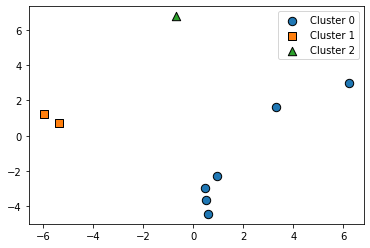

In [ ]:
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(customer_info_sc)

pcaDF = customer_info_kmeans[['Cluster']]
pcaDF['ftr1'] = pca_transformed[:, 0]
pcaDF['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(kmeans, pcaDF, 'Cluster', iscenter=False)

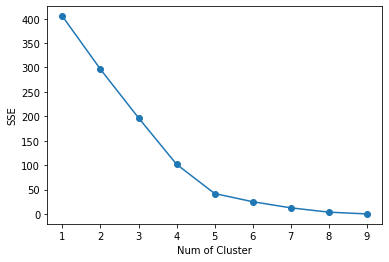

In [ ]:
# Elbow
def elbow(X):
  sse = []
  for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

  plt.plot(range(1, 10), sse, marker='o')
  plt.xlabel('Num of Cluster')
  plt.ylabel('SSE')
  plt.show()

elbow(customer_info_sc)

In [ ]:
def visualize_silhouette(cluster_lists, X_features): 
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


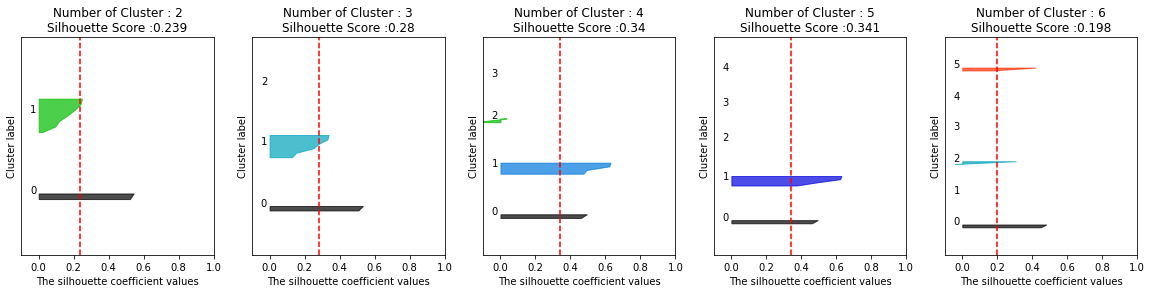

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], customer_info_sc)

In [ ]:
dbscan = DBSCAN(eps=5, min_samples=2, metric='euclidean')
dbscan_labels = dbscan.fit_predict(customer_info_sc)

In [ ]:
customer_info_dbscan = customer_info_sc.copy()
customer_info_dbscan['Cluster'] = dbscan_labels
customer_info_dbscan

,상품개수,총매수금액,총매수수량,ETF,kosdaq_cap,large_cap,medium_cap,small_cap,Industry,etf보유기간,우량주보유기간,중형주보유기간,소형주보유기간,kosdaq보유기간,kosdaq_cap_PER,large_cap_PER,medium_cap_PER,small_cap_PER,kosdaq_cap_PBR,large_cap_PBR,medium_cap_PBR,small_cap_PBR,kosdaq_cap_ROE,large_cap_ROE,medium_cap_ROE,small_cap_ROE,kosdaq_cap_DY,large_cap_DY,medium_cap_DY,small_cap_DY,매도매수일치_외국인,매도매수일치_기관,ETF_TR,kosdaq_cap_TR,large_cap_TR,medium_cap_TR,small_cap_TR,ETF_ATR_7,kosdaq_cap_ATR_7,large_cap_ATR_7,medium_cap_ATR_7,small_cap_ATR_7,ETF_ATR_14,kosdaq_cap_ATR_14,large_cap_ATR_14,medium_cap_ATR_14,small_cap_ATR_14,Cluster
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C000100_1,0.000000,0.290591,-0.540093,0.495364,-0.643178,0.300679,-0.353553,-0.532485,-0.441942,-0.192047,-0.350155,0.0,-0.516694,-0.465223,-0.353553,-0.112594,-0.353553,-0.468909,-0.360508,-0.199992,-0.353553,-0.512386,-0.353553,-0.145679,-0.353553,-0.463706,-0.353553,1.046848,-0.353553,0.0,1.605704,-0.917784,1.693416,-0.354416,-0.174236,-0.353553,-0.514055,1.649119,-0.354535,-0.148028,-0.353553,-0.520965,1.519826,-0.355018,-0.204144,-0.353553,-0.531279,0
C000100_2,0.000000,0.769825,-0.537821,-0.870806,-0.643178,2.168319,-0.353553,-0.532485,0.353553,-0.795417,-0.321221,0.0,-0.516694,-0.465223,-0.353553,2.363317,-0.353553,-0.468909,-0.360508,2.816778,-0.353553,-0.512386,-0.353553,0.393406,-0.353553,-0.463706,-0.353553,2.349664,-0.353553,0.0,0.910046,-0.269289,-0.721332,-0.354416,2.763540,-0.353553,-0.514055,-0.713019,-0.354535,2.563294,-0.353553,-0.520965,-0.717391,-0.355018,2.361956,-0.353553,-0.531279,-1
C000100_3,0.000000,-0.024964,-0.440823,-0.870806,-0.643178,0.976497,2.828427,-0.532485,0.353553,-0.795417,-0.355325,0.0,-0.516694,-0.465223,-0.353553,1.158219,2.828427,-0.468909,-0.360508,-0.177578,2.828427,-0.512386,-0.353553,2.204572,2.828427,-0.463706,-0.353553,0.188327,2.828427,0.0,-1.059201,1.566453,-0.721332,-0.354416,0.175410,2.828427,-0.514055,-0.713019,-0.354535,0.793324,2.828427,-0.520965,-0.717391,-0.355018,1.197463,2.828427,-0.531279,-1
C00010_1,1.224745,-0.769664,0.238395,-0.870806,0.528831,-0.780474,-0.353553,2.048748,1.149049,-0.795417,-0.360305,0.0,2.351739,0.580081,-0.353553,-0.632388,-0.353553,0.622870,-0.331012,-0.415857,-0.353553,2.397507,-0.353553,-0.722913,-0.353553,0.567801,-0.353553,-0.680313,-0.353553,0.0,0.910046,0.422440,-0.721332,-0.349803,-0.491215,-0.353553,2.380592,-0.713019,-0.350835,-0.580375,-0.353553,2.298122,-0.717391,-0.350756,-0.607262,-0.353553,2.092820,-1
C00010_2,1.224745,-0.324352,2.629514,-0.870806,1.076465,-0.780474,-0.353553,1.678645,1.149049,-0.795417,-0.360305,0.0,1.265117,2.674080,-0.353553,-0.632388,-0.353553,2.659493,-0.334186,-0.415857,-0.353553,1.189195,-0.353553,-0.722913,-0.353553,2.678141,-0.353553,-0.680313,-0.353553,0.0,0.115009,0.471849,-0.721332,-0.352125,-0.491215,-0.353553,1.217791,-0.713019,-0.350377,-0.580375,-0.353553,1.348631,-0.717391,-0.347557,-0.607262,-0.353553,1.626132,-1
C00010_3,1.224745,2.402524,0.433074,-0.870806,2.253773,0.456878,-0.353553,-0.532485,1.149049,-0.795417,2.828225,0.0,-0.516694,-0.462824,2.828427,-0.247003,-0.353553,-0.468909,2.828243,-0.359921,-0.353553,-0.512386,2.828427,1.162265,-0.353553,-0.463706,2.828427,-0.183273,-0.353553,0.0,0.353520,-0.528687,-0.721332,2.828424,-0.308642,-0.353553,-0.514055,-0.713019,2.828423,-0.306713,-0.353553,-0.520965,-0.717391,2.828418,-0.318967,-0.353553,-0.531279,-1
C0001_1,-1.224745,-0.746138,-0.663215,1.286222,-0.643178,-0.780474,-0.353553,-0.532485,-1.237437,1.327653,-0.360305,0.0,-0.516694,-0.465223,-0.353553,-0.632388,-0.353553,-0.468909,-0.360508,-0.415857,-0.353553,-0.512386,-0.353553,-0.722913,-0.353553,-0.463706,-0.353553,-0.680313,-0.353553,0.0,-0.203006,-0.961018,1.797822,-0.354416,-0.491215,-0.353553,-0.514055,1.838068,-0.354535,-0.580375,-0.353553,-0.520965,1.938430,-0.355018,-0.607262,-0.353553,-0.531279,0
C0001_2,-1.224745,-0.897285,-0.562809,1.286222,-0.643178,-0.780474,-0.353553,-0.532485,-1.237437,1.421802,-0.360305,0.0,-0.516694,-0.465223,-0.353553,-0.632

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


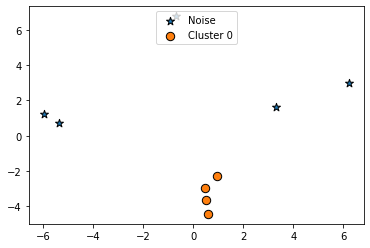

In [ ]:
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(customer_info_sc)

# pcaDF = pd.DataFrame()
customer_info_dbscan['ftr1'] = pca_transformed[:, 0]
customer_info_dbscan['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(dbscan, customer_info_dbscan, 'Cluster', iscenter=False)